The tutorial shows how to genenerate frequency-dependent antenna-responses and detector responses. Further, this tutorial also shows how to define likelihood objects compatible with these waveforms. For this you need to install the freq_dep_antenna_response_HM branch from  https://git.ligo.org/pratyusava.baral/bilby-x-g/-/tree/freq_dep_antenna_response_HM/examples/tutorials?ref_type=heads

In [1]:
import bilby
import numpy as np
from bilby.core.utils import ra_dec_to_theta_phi, speed_of_light
from bilby.core.utils.constants import *
import bilby.gw.utils as gwutils
from copy import deepcopy
import matplotlib.pyplot as plt


Define the parameters of the waveform.

In [2]:
mass_1 = 3
mass_2 = 1
ra = 3.44616
dec = -0.408084 
theta_jn = 1.57
psi = 1.57
phase = 1.57
geocent_time = 630696093
luminosity_distance = 35
mode_array=[[2,2],[3,2],[3,3],[4,4]]


z = bilby.gw.conversion.luminosity_distance_to_redshift(luminosity_distance)
q = bilby.gw.conversion.component_masses_to_mass_ratio(mass_1, mass_2)
detector_frame_chirp_mass = bilby.gw.conversion.component_masses_to_chirp_mass(mass_1, mass_2) * (1+z)

injection_parameters = dict(
    chirp_mass=detector_frame_chirp_mass, mass_ratio=q, chi_1=0., chi_2=0.,
    ra=ra, dec=dec, luminosity_distance = luminosity_distance,
    theta_jn=theta_jn, psi=psi, phase=phase, geocent_time=geocent_time, fiducial=1,
)


Define the interferometer

In [3]:
CE40km_1p0MW_Aplus_coat_strain_file = '../asd/CE40km_1p0MW_Aplus_coat_strain.txt'
CE40_detector_file = '../detector_configurations/bilby/CE40.ifo'

In [4]:
# Load the noise curve - correct function name
frequencies_asd, strain_asd = np.loadtxt(CE40km_1p0MW_Aplus_coat_strain_file, unpack=True)


ifos = bilby.gw.detector.InterferometerList([])
ifo = bilby.gw.detector.load_interferometer(CE40_detector_file)
ifos.append(ifo)

# Set the power spectral density from the noise curve file
ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=frequencies_asd,
    asd_array=strain_asd  # Convert ASD to PSD
)


In [5]:
minimum_frequency = 5
sampling_frequency = 4096
reference_frequency = 100
tc_offset = 1
waveformname = "IMRPhenomXPHM"

chirp_mass_in_seconds = detector_frame_chirp_mass * solar_mass * gravitational_constant / speed_of_light**3.
t0 = -5. / 256. * chirp_mass_in_seconds * (np.pi * chirp_mass_in_seconds * minimum_frequency)**(-8. / 3.)
duration = 2**(np.int32(np.log2(np.abs(t0)))+1)
start_time = injection_parameters["geocent_time"] - duration + tc_offset


waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole_individual_modes,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(waveform_approximant=waveformname, reference_frequency=reference_frequency, minimum_frequency=minimum_frequency, mode_array=mode_array))



15:03 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole_individual_modes
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


For next-generation detectors the antenna responses are not only frequency-dependent, but also depends on the azimuthal mode, chirp nass and the source position.

In [6]:
frequencies = waveform_generator.frequency_array
idxs_above_minimum_frequency = frequencies > (minimum_frequency - (frequencies[1] - frequencies[0]))
freqs = frequencies[idxs_above_minimum_frequency]

converted_injection_parameters, _ = waveform_generator.parameter_conversion(injection_parameters)
waveform_polarizations = waveform_generator.frequency_domain_strain(converted_injection_parameters)
waveform_polarizations_reduced = {}


parameters = deepcopy(converted_injection_parameters)
times_to_coalescence_m_2 = gwutils.calculate_time_to_merger_for_any_mode(
                freqs, parameters['mass_1'], parameters['mass_2'], parameters['chi_1'],
                parameters['chi_2'], mode=2, safety=1)

times_to_coalescence_m_3 = gwutils.calculate_time_to_merger_for_any_mode(
                freqs, parameters['mass_1'], parameters['mass_2'], parameters['chi_1'],
                parameters['chi_2'], mode=3, safety=1)

times_to_coalescence_m_4 = gwutils.calculate_time_to_merger_for_any_mode(
                freqs, parameters['mass_1'], parameters['mass_2'], parameters['chi_1'],
                parameters['chi_2'], mode=4, safety=1)

fps_2, fcs_2 = ifo.frequency_dependent_antenna_response(
    ra = converted_injection_parameters["ra"],
    dec = converted_injection_parameters["dec"],
    time = converted_injection_parameters["geocent_time"],
    psi = converted_injection_parameters["psi"],
    times_to_coalescence = times_to_coalescence_m_2,
    frequencies = freqs,
    start_time = start_time,
    earth_rotation_time_delay=True,
    earth_rotation_beam_patterns=True,
    finite_size=True,
)

fps_3, fcs_3 = ifo.frequency_dependent_antenna_response(
    ra = converted_injection_parameters["ra"],
    dec = converted_injection_parameters["dec"],
    time = converted_injection_parameters["geocent_time"],
    psi = converted_injection_parameters["psi"],
    times_to_coalescence = times_to_coalescence_m_3,
    frequencies = freqs,
    start_time = start_time,
    earth_rotation_time_delay=True,
    earth_rotation_beam_patterns=True,
    finite_size=True,
)

fps_4, fcs_4 = ifo.frequency_dependent_antenna_response(
    ra = converted_injection_parameters["ra"],
    dec = converted_injection_parameters["dec"],
    time = converted_injection_parameters["geocent_time"],
    psi = converted_injection_parameters["psi"],
    times_to_coalescence = times_to_coalescence_m_4,
    frequencies = freqs,
    start_time = start_time,
    earth_rotation_time_delay=True,
    earth_rotation_beam_patterns=True,
    finite_size=True,
)

/Users/pbaral/Documents/Research/bilby-x-g/bilby/gw/source.py:622: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


[]

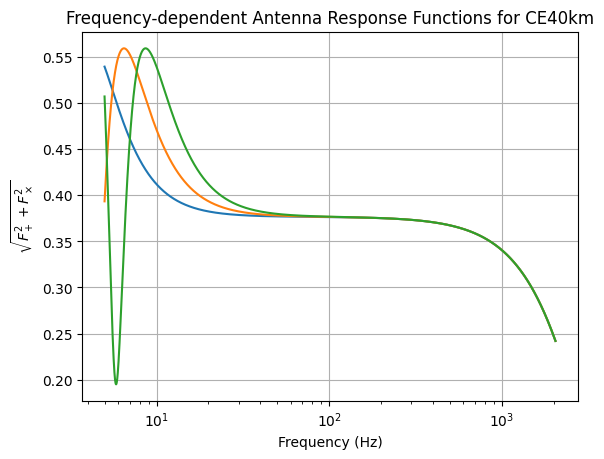

In [7]:
plt.plot(freqs, np.sqrt(np.abs(fps_2)**2 + np.abs(fcs_2)**2), label='Mode 2')
plt.plot(freqs, np.sqrt(np.abs(fps_3)**2 + np.abs(fcs_3)**2), label='Mode 3')
plt.plot(freqs, np.sqrt(np.abs(fps_4)**2 + np.abs(fcs_4)**2), label='Mode 4')
plt.title('Frequency-dependent Antenna Response Functions for CE40km')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\sqrt{F_+^2 + F_\times^2}$')
plt.grid()
plt.semilogx()


In [8]:
# Define file paths
CE40km_1p0MW_Aplus_coat_strain_file = '../asd/CE40km_1p0MW_Aplus_coat_strain.txt'
CE40_detector_file = '../detector_configurations/bilby/CE40.ifo'



In [9]:
# Load the noise curve - correct function name
frequencies_asd, strain_asd = np.loadtxt(CE40km_1p0MW_Aplus_coat_strain_file, unpack=True)


ifos = bilby.gw.detector.InterferometerList([])
ifo = bilby.gw.detector.load_interferometer(CE40_detector_file)
ifos.append(ifo)

# Set the power spectral density from the noise curve file
ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=frequencies_asd,
    asd_array=strain_asd  # Convert ASD to PSD
)


We can also calculate and plot waveform polarizations.

In [10]:
frequencies = waveform_generator.frequency_array
idxs_above_minimum_frequency = frequencies > (minimum_frequency - (frequencies[1] - frequencies[0]))
freqs = frequencies[idxs_above_minimum_frequency]


for key in waveform_polarizations.keys():
    waveform_polarizations_reduced[key] = {}
    waveform_polarizations_reduced[key]['plus'] = waveform_polarizations[key]['plus'][idxs_above_minimum_frequency]
    waveform_polarizations_reduced[key]['cross'] = waveform_polarizations[key]['cross'][idxs_above_minimum_frequency]

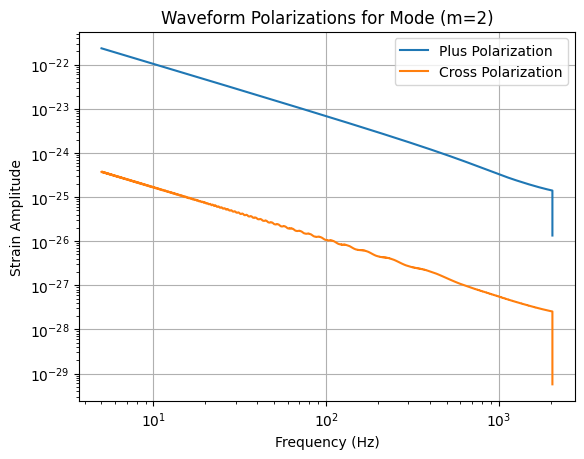

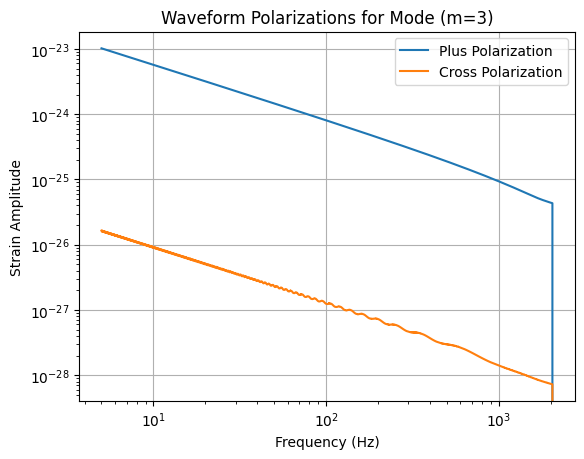

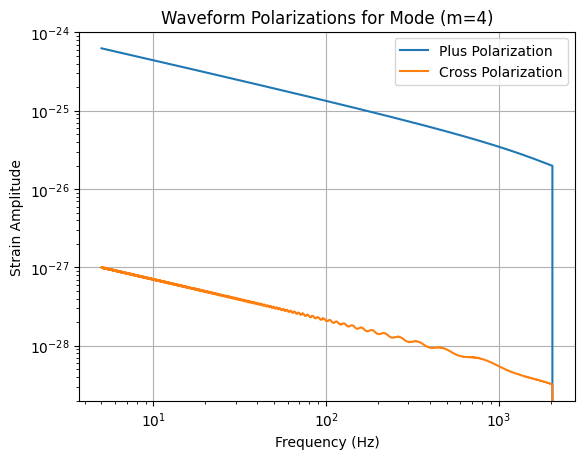

In [11]:
#plot waveform polarizations
import matplotlib.pyplot as plt
for m in [2,3,4]:
    plt.loglog(freqs, np.abs(waveform_polarizations_reduced[str(m)]['plus']), label='Plus Polarization')
    plt.loglog(freqs, np.abs(waveform_polarizations_reduced[str(m)]['cross']), label='Cross Polarization')
    plt.title(f'Waveform Polarizations for Mode (m={m})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Strain Amplitude')
    plt.legend()
    plt.grid()
    plt.show()

Now we generate the waveform and calculate its optimal SNR in CE.

In [12]:
h = np.zeros_like(waveform_generator.frequency_array, dtype=complex)
h[idxs_above_minimum_frequency] = ifo.get_detector_response_for_frequency_dependent_antenna_response(
    waveform_polarizations = waveform_polarizations_reduced,
    parameters = converted_injection_parameters,
    start_time = start_time,
    frequencies = freqs,
    earth_rotation_time_delay=True,
    earth_rotation_beam_patterns=True,
    finite_size=True,)
    
ifo.set_strain_data_from_frequency_domain_strain(
        h, start_time=start_time, frequency_array=frequencies
    )
ifo.minimum_frequency = minimum_frequency
snr = ifo.optimal_snr_squared(signal=ifo.frequency_domain_strain)
snr = np.sqrt(snr.real)
log_likelihood_ratio_at_injected_value = 0.5 * snr ** 2

print(f"The injected SNR is {snr}.")
print(f"The log likelihood ratio at the injected value is {log_likelihood_ratio_at_injected_value}.")

The injected SNR is 609.527556916086.
The log likelihood ratio at the injected value is 185761.92132004624.


/var/folders/81/zjs6tlpx55qfk26zjcjz0v8w0000gr/T/ipykernel_86802/1306847051.py:2: RuntimeWarning: invalid value encountered in divide
  plt.loglog(ifo.frequency_array, np.abs(ifo.frequency_domain_strain)**2/(ifo.frequency_array), label='Signal Strain')


Text(0, 0.5, 'Spectral Density(Strain^2 / Hz)')

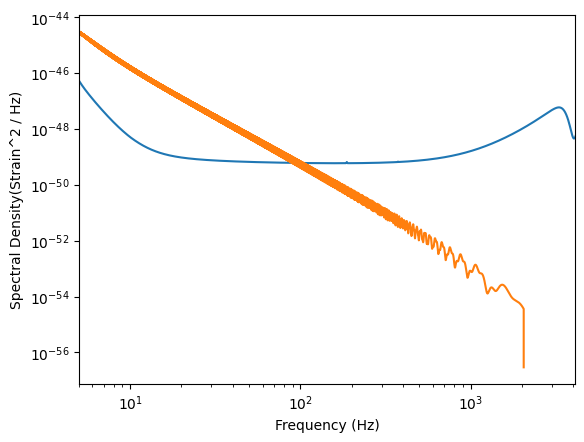

In [13]:
plt.loglog(frequencies_asd, strain_asd**2, label='ASD')
plt.loglog(ifo.frequency_array, np.abs(ifo.frequency_domain_strain)**2/(ifo.frequency_array), label='Signal Strain')
plt.xlim(5, 4096)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Spectral Density(Strain^2 / Hz)')


The functionality to only print out the antenna response exists. Please note unlike the `interferometer.antenna_response` function in bilby, this function also calculates incorporates the time delay from the geocenter term.

We know define the likelihood functions. We can define a basic GW likelihood or a multibanded likelihood or a relative binning likelihood.

Set up a basic likelihood

In [14]:
priors_basic = bilby.gw.prior.BNSPriorDict()
likelihood = bilby.gw.likelihood.GravitationalWaveTransientNextGeneration(
    interferometers=ifos, waveform_generator=waveform_generator, priors=priors_basic,
    distance_marginalization=False, phase_marginalization=False,
    time_reference='geocent', earth_rotation_time_delay = True,
    earth_rotation_beam_patterns = True, finite_size = True, 
)

params = deepcopy(converted_injection_parameters)
likelihood.parameters.update(params)

log_likelihood_ratio = likelihood.log_likelihood_ratio()
print(f"Log likelihood at injected parameters: {log_likelihood_ratio}")
print(f"Error in log likelihood at injected parameters: {log_likelihood_ratio - log_likelihood_ratio_at_injected_value}")

15:06 bilby INFO    : No prior given, using default BNS priors in /Users/pbaral/Documents/Research/bilby-x-g/bilby/gw/prior_files/aligned_spins_bns_tides_on.prior.


Log likelihood at injected parameters: 185761.92132004627
Error in log likelihood at injected parameters: 2.9103830456733704e-11


We now will use the multibanding approximation therefore need a new waveform generator

In [15]:
search_waveform_generator_MB = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.binary_black_hole_individual_modes_frequency_sequence,#_individual_modes,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(waveform_approximant=waveformname, reference_frequency=reference_frequency, minimum_frequency=minimum_frequency, mode_array=mode_array))

priors_MB = bilby.gw.prior.BNSPriorDict()
priors_MB['geocent_time'] = bilby.core.prior.Uniform(
        minimum=injection_parameters['geocent_time'] - 0.1,
        maximum=injection_parameters['geocent_time'] + 0.1,
        name='geocent_time', latex_label='$t_c$', unit='$s$'
    )
likelihood_MB = bilby.gw.likelihood.MBGravitationalWaveTransientNextGeneration(
        interferometers=ifos, waveform_generator=search_waveform_generator_MB, priors=priors_MB,
        reference_chirp_mass=detector_frame_chirp_mass-1e-5, linear_interpolation=True,
        distance_marginalization=False,
        phase_marginalization=False, 
        time_reference='geocent',
        accuracy_factor = 5,
        highest_mode = 4,
        earth_rotation_time_delay = True,
        earth_rotation_beam_patterns = True,
        finite_size = True,
        response_update = None
    )
params = deepcopy(converted_injection_parameters)
likelihood_MB.parameters.update(params)

log_likelihood_ratio = likelihood_MB.log_likelihood_ratio()
print(f"Log likelihood at injected parameters: {log_likelihood_ratio}")
print(f"Error in log likelihood at injected parameters: {log_likelihood_ratio - log_likelihood_ratio_at_injected_value}")

15:07 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.binary_black_hole_individual_modes_frequency_sequence
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:07 bilby INFO    : No prior given, using default BNS priors in /Users/pbaral/Documents/Research/bilby-x-g/bilby/gw/prior_files/aligned_spins_bns_tides_on.prior.
15:07 bilby INFO    : The total frequency range is divided into 13 bands with frequency intervals of 1/8192.0 Hz, 1/4096.0 Hz, 1/2048.0 Hz, 1/1024.0 Hz, 1/512.0 Hz, 1/256.0 Hz, 1/128.0 Hz, 1/64.0 Hz, 1/32.0 Hz, 1/16.0 Hz, 1/8.0 Hz, 1/4.0 Hz, 1/2.0 Hz.
15:07 bilby INFO    : The number of frequency points where waveforms are evaluated is 88096.
15:07 bilby INFO    : The speed-up gain of multi-banding is 189.97747911369416.
15:07 bilby INFO    : Pre-computing linear coefficients for CE40
15:07 bilby INFO    : Linear-interpolation algorithm is used for (

Log likelihood at injected parameters: 185761.92213192422
Error in log likelihood at injected parameters: 0.0008118779805954546


We now set up a relative binning likelihood.

In [16]:
search_waveform_generator_RB = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole_relative_binning_individual_modes,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    waveform_arguments=dict(waveform_approximant=waveformname, reference_frequency=reference_frequency, minimum_frequency=minimum_frequency, mode_array=mode_array))

priors_RB = bilby.gw.prior.BNSPriorDict()
priors_RB['fiducial'] = 0
priors_RB['geocent_time'] = bilby.core.prior.Uniform(630696093-1, 630696093+1)
likelihood_RB = bilby.gw.likelihood.RelativeBinningGravitationalWaveTransientNextGenerationModebyMode(
        interferometers=ifos, waveform_generator=search_waveform_generator_RB, priors=priors_RB,
        distance_marginalization=False,
        phase_marginalization=False, 
        time_reference='geocent',
        chi=5,
        epsilon=0.1,
        fiducial_parameters=injection_parameters,
        earth_rotation_time_delay = True,
        earth_rotation_beam_patterns = True,
        finite_size = True,
    )

15:07 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole_relative_binning_individual_modes
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters
15:07 bilby INFO    : No prior given, using default BNS priors in /Users/pbaral/Documents/Research/bilby-x-g/bilby/gw/prior_files/aligned_spins_bns_tides_on.prior.
15:08 bilby INFO    : Initial fiducial waveforms set up
15:33 bilby INFO    : Summary Data Obtained
15:33 bilby INFO    : Fiducial likelihood: 185761.91


In [17]:
params = deepcopy(converted_injection_parameters)
params['fiducial'] = 0
likelihood_RB.parameters.update(params)
print(f"Log likelihood at injected parameters: {likelihood_RB.log_likelihood_ratio()}")
print(f"Error in log likelihood at injected parameters: {likelihood_RB.log_likelihood_ratio() - log_likelihood_ratio_at_injected_value}")


Log likelihood at injected parameters: 185761.91269109526
Error in log likelihood at injected parameters: -0.00862895097816363
